In [1]:
import numpy as np
import math
import matplotlib.pylab as pyplt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


$y = \frac{ln((\alpha x + e) -1)}{ln((\alpha + e) - 1)}$


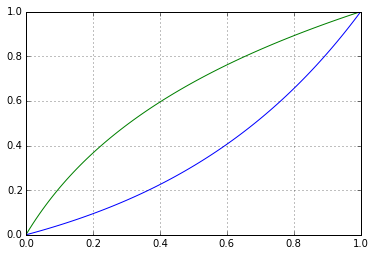

In [3]:
#This notebook implements a logarithmic mesh refinement of the unit; we use the above function as well as its inverse
alpha = 11
yorig = np.linspace(0.00,1,100)

y2 = [(math.log(alpha*Y + math.e) - 1.)*(1./(math.log(alpha + math.e) - 1)) for Y in yorig ]
y3 = [(math.e**(Y*(math.log(alpha + math.e) - 1) + 1 ) - math.e)/alpha for Y in yorig ]
pyplot.plot(yorig, y3)
pyplot.plot(yorig, y2)
pyplot.grid()

In [151]:
alpha = 11.
res = 256
dyo = 1./res

dyn = 1. - (math.log(alpha*(1- dyo ) + math.e) - 1.)*(1./(math.log(alpha + math.e) - 1))

print(dyo, dyn, (dyo/dyn))

(0.00390625, 0.001938026862393638, 2.015580937394969)


In [152]:
### print((math.log(alpha*0. + math.e) - 1)*(1/(math.log(alpha + math.e) - 1)), (math.log(alpha*1. + math.e) - 1)*(1/(math.log(alpha + math.e) - 1)))
print((math.e**(0*(math.log(alpha + math.e) - 1) + 1 ) - math.e)/alpha, (math.e**(1.*(math.log(alpha + math.e) - 1) + 1 ) - math.e)/alpha)

#(math.e**(0.*math.log(alpha + math.e)) - math.e)/alpha

(0.0, 0.9999999999999999)


In [153]:
# RT PIC - classic and nearest neighbour
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np
import os
from shapely.geometry import Polygon
from shapely.geometry import Point

In [165]:
dim = 2

meshX = 64
meshY = 64

In [166]:
# create mesh objects
elementMesh = uw.mesh.FeMesh_Cartesian( elementType='Q1/dQ0', 
                                         elementRes=(meshX, meshY), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(1.,1.0))
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh

In [167]:
# create fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

In [168]:
for index, coord in enumerate(linearMesh.data):
    if coord[1] < 0.7:
        temperatureField.data[index] = 0.5  
    else:
        temperatureField.data[index] = 1. - coord[1]
    

In [169]:
#(math.log(0 + 0.001)/alpha + 1) + abs((math.log(0.0 + 0.001)/alpha + 1))

In [170]:
#THis one for the rectangonal mesh
alpha = 1.
newys = []
newxs = []
for index, coord in enumerate(linearMesh.data):
    y0 = coord[1]
    x0 = abs(coord[0])
    newy = (math.log(alpha*y0 + math.e) - 1)*(1/(math.log(alpha + math.e) - 1))
    if coord[0] > 0:
        newx = (math.e**(x0*(math.log((alpha/2.) + math.e) - 1) + 1 ) - math.e)/(alpha/2.)     
    else:
        newx = -1.*(math.e**(x0*(math.log((alpha/2.) + math.e) - 1) + 1 ) - math.e)/(alpha/2.)
    newys.append(newy)
    newxs.append(newx)
    #print y0,newy

In [171]:
#THis one for the square mesh

alpha = 11.
newys = []
newxs = []
for index, coord in enumerate(linearMesh.data):
    y0 = coord[1]
    x0 = abs(coord[0])
    newy = (math.log(alpha*y0 + math.e) - 1)*(1/(math.log(alpha + math.e) - 1))
    newx = (math.log(alpha*x0 + math.e) - 1)*(1/(math.log(alpha + math.e) - 1))
    newys.append(newy)
    newxs.append(newx)

In [172]:
linearMesh.data[:,1]

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

In [173]:
with linearMesh.deform_mesh():
    linearMesh.data[:,1] = newys
    linearMesh.data[:,0] = newxs


In [174]:

    
#figtemp = plt.Figure()
#figtemp.Surface(temperatureField, elementMesh)
#figtemp.Surface(indexField, elementMesh)
#figtemp.Mesh(linearMesh, colourBar=False)
#figtemp.show()

In [175]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, elementMesh)
#figtemp.Surface(indexField, elementMesh)
figtemp.Mesh(linearMesh, colourBar=False)
figtemp.save_database('test_mesh_refine.gldb')

In [176]:
#indexField = uw.fevariable.FeVariable( feMesh=linearMesh, nodeDofCount=1)

#for index, coord in enumerate(linearMesh.data):
#     indexField.data[index] = ((index % (meshX+1)) % 2 ==0)
#    indexField.data[index] = ((index/(meshX+1) % (meshY+1)) % 2 ==0)


#figindex = plt.Figure()
#figindex.Surface(indexField, elementMesh)
#figindex.Mesh(linearMesh, colourBar=False)
#figindex.show()

In [145]:
#indexField.evaluate((0.5,0.26))

In [146]:
#linearMesh._cself.isRegular#

In [20]:
Ra=1.e6
rho = 4.0e3
grav = 10
height = 1.e6
kappa = 1.0e-6

# Set a constant viscosity.
viscosity = 1.

# Create our density function.
densityFn = Ra * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# A buoyancy function.
buoyancyFn = densityFn * z_hat

# The temperature gradient is useful in the analysis below. We access it via the 'gradientFn' attribute provided
# via the FeVariable.
gradField = temperatureField.gradientFn

In [21]:
iWalls = elementMesh.specialSets["MinI_VertexSet"] + elementMesh.specialSets["MaxI_VertexSet"]
jWalls = elementMesh.specialSets["MinJ_VertexSet"] + elementMesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition(     variable = velocityField, 
                                              nodeIndexSets = (iWalls,jWalls) )
tempBC     = uw.conditions.DirichletCondition(     variable = temperatureField, 
                                              nodeIndexSets = (jWalls,) )

In [22]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               viscosityFn   = viscosity, 
                               bodyForceFn   = buoyancyFn )

In [23]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,], )

In [24]:
stokesPIC.solve()

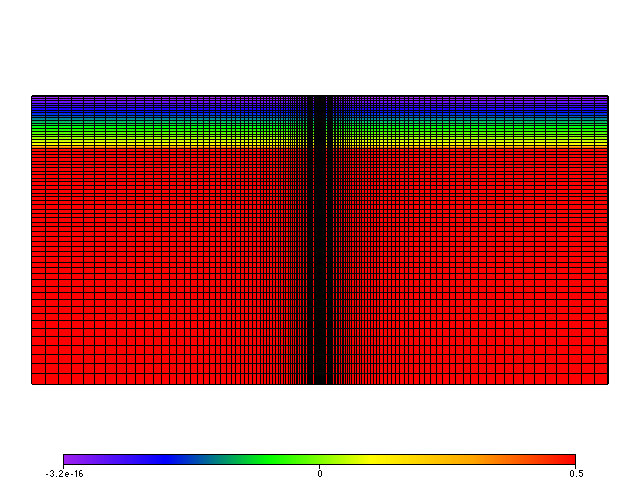

In [36]:
fig2 = plt.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
#fig2.VectorArrows( velocityField, elementMesh, arrowHeadSize=0.2, lengthScale=10.1 )
fig2.Surface( temperatureField, elementMesh )
fig2.Mesh(linearMesh)
fig2.show()